In [1]:
!pip install statsmodels --quiet

You should consider upgrading via the '/Users/danielmiller/.pyenv/versions/3.9.15/envs/torch_rl/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
USE_GPU = False
from typing import List, Tuple, Dict, Any, Optional
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import re

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
import glob
from typing import Dict
from statsmodels.tsa.filters.hp_filter import hpfilter
import re
from datetime import datetime

In [4]:
CORE_S3_PATH = 's3://dissertation-data-dmiller'

In [25]:


def tensorboard_results_reward(log_matrix: Dict):
    log_df = {}
    for label, log_dir in log_matrix.items():
        print(f'Getting {label} results')
        events = EventAccumulator(log_dir)
        events.Reload()
        reward = events.Scalars('rollout/ep_rew_mean')
        df = pd.DataFrame({
                'wall_time': [x.wall_time for x in reward], # 'step': [x.step for x in loss],
                'step': [x.step for x in reward],
                'reward': [x.value for x in reward],
            })
        df['wall_time'] = pd.to_datetime(df['wall_time'], unit='s')
        log_df[label] = df
        
    return log_df


def tensorboard_results_loss(log_matrix: Dict):
    log_df = {}
    for label, log_dir in log_matrix.items():
        print(f'Getting {label} results')
        events = EventAccumulator(log_dir)
        events.Reload()
        reward = events.Scalars('train/loss')
        df = pd.DataFrame({
                'wall_time': [x.wall_time for x in reward], # 'step': [x.step for x in loss],
                'step': [x.step for x in reward],
                'loss': [x.value for x in reward],
            })
        df['wall_time'] = pd.to_datetime(df['wall_time'], unit='s')
        log_df[label] = df
        
    return log_df

        

def convolve_and_apply_hp_filter(df, col, window, lamb):
    df = df.set_index('wall_time') \
        .resample(f'{window}T') \
        .mean() \
        .reset_index()
    
    df['step'] = df['step'].astype(int)
    
    cycle, trend = hpfilter(df[col], lamb)
    df[f'hp_{col}'] = trend
    return df

def fetch_end_filtered(df_matrix, col):
    filtered_df = []
    for k, v in df_matrix.items():
        filtered_df.append(
            {
                "Exp Name": k,
                col: v.iloc[-1][col]
            }
        )
    return pd.DataFrame(filtered_df)


def fetch_session_stats(log_matrix: Dict):
    for label, log_dir in log_matrix.items():
        print(f'Getting {label} results')
        scalar_container = []
        events = EventAccumulator(log_dir)
        events.Reload()
        for scalar in ['inc_time', 'reward', 'session_minutes', 'sim_minutes']:
            print(f'Getting {scalar} results')
            result = events.Scalars(f'time/{scalar}')
            scalar_df = pd.DataFrame({
                    'wall_time': [x.wall_time for x in result], # 'step': [x.step for x in loss],
                    'step': [x.step for x in result],
                    scalar: [x.value for x in result],
                })
            scalar_df['wall_time'] = pd.to_datetime(scalar_df['wall_time'], unit='s')
            scalar_container.append(scalar_df)
        df = pd.concat(scalar_container, axis=1, join='outer')
        df = df.loc[:,~df.columns.duplicated()]
        df['distance_sess_reward'] = df['session_minutes'] - df['reward']
        df['distance_sim_reward'] = df['reward'] - df['sim_minutes']
        df['distance_inc_pl'] = df['sim_minutes'] - df['inc_time']
        
        label_prefix = re.sub(r'[^a-zA-Z0-9]', '_', label).lower()
        df.to_csv(f'rl_stats/q_1_cnn/experiment_stats/{label_prefix}_stats.csv', index=False)
        log_matrix[label] = df
    return log_matrix


def fetch_end_evaluation(df_matrix):
    end_evaluation_container = []
    for label, df in df_matrix.items():
        end_evaluation_container.append(
            {
                "Exp Name": label,
                'HP Reward': df.iloc[-1]['hp_reward'],
                'HP Distance Session': df.iloc[-1]['hp_distance_sess_reward'],
                'HP Inc Placements': df.iloc[-1]['hp_distance_inc_pl'],
            }
        )
   
   
    return pd.DataFrame(end_evaluation_container)
 
SUMMARY_STAT_COLS = [
    'distance_sess_reward', 
    'distance_sim_reward', 
    'distance_inc_pl', 
    'reward', 
    'session_minutes', 
    'sim_minutes'
]




In [35]:
log_dirs_q1_dqn = {
    'DQN LABEL CNN': 'rl_experiments/n_files_30/cnn_label/2023-06-01_17-39-27/training_metrics/DQN_1',
    'DQN PRED CNN': 'rl_experiments/n_files_30/cnn_seq_40/2023-06-01_17-36-23/training_metrics/DQN_1',
    'DQN NONE CNN': 'rl_experiments/n_files_30/cnn_None/2023-06-01_20-18-43/training_metrics/DQN_1'
}

log_dirs_q1 = log_dirs_q1_dqn.copy()
log_dirs_q1 = {
    k: os.path.join(CORE_S3_PATH, v) for k, v in log_dirs_q1.items()
}


results_dir = os.path.join('rl_stats', 'q_1_cnn')

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [36]:
df_summary_stats = fetch_session_stats(log_dirs_q1)

Getting DQN LABEL CNN results
Getting inc_time results
Getting reward results
Getting session_minutes results
Getting sim_minutes results
Getting DQN PRED CNN results
Getting inc_time results
Getting reward results
Getting session_minutes results
Getting sim_minutes results
Getting DQN NONE CNN results
Getting inc_time results
Getting reward results
Getting session_minutes results
Getting sim_minutes results


In [37]:
for exp_name, df in df_summary_stats.items():
    print(f'Running conv on {exp_name}')
    for col in SUMMARY_STAT_COLS:
        print(f'Convolving {col}')
        df = df[(df['step'] > 52_000) & (df['step'] < 17_500_000) ]
        df = convolve_and_apply_hp_filter(df.copy(), col, 5, 100)
    df_summary_stats[exp_name] = df

Running conv on DQN LABEL CNN
Convolving distance_sess_reward
Convolving distance_sim_reward
Convolving distance_inc_pl
Convolving reward
Convolving session_minutes
Convolving sim_minutes
Running conv on DQN PRED CNN
Convolving distance_sess_reward
Convolving distance_sim_reward
Convolving distance_inc_pl
Convolving reward
Convolving session_minutes
Convolving sim_minutes
Running conv on DQN NONE CNN
Convolving distance_sess_reward
Convolving distance_sim_reward
Convolving distance_inc_pl
Convolving reward
Convolving session_minutes
Convolving sim_minutes


\begin{tabular}{lrrr}
\toprule
Exp Name & HP Reward & HP Distance Session & HP Inc Placements \\
\midrule
DQN LABEL CNN & 1580.701465 & 20.581725 & 1083.994588 \\
DQN PRED CNN & 1619.785382 & 20.579479 & 1089.123342 \\
DQN NONE CNN & 1803.851363 & 382.820633 & 978.468633 \\
\bottomrule
\end{tabular}



,Exp Name,HP Reward,HP Distance Session,HP Inc Placements
0,DQN LABEL CNN,1580.701465,20.581725,1083.994588
1,DQN PRED CNN,1619.785382,20.579479,1089.123342
2,DQN NONE CNN,1803.851363,382.820633,978.468633


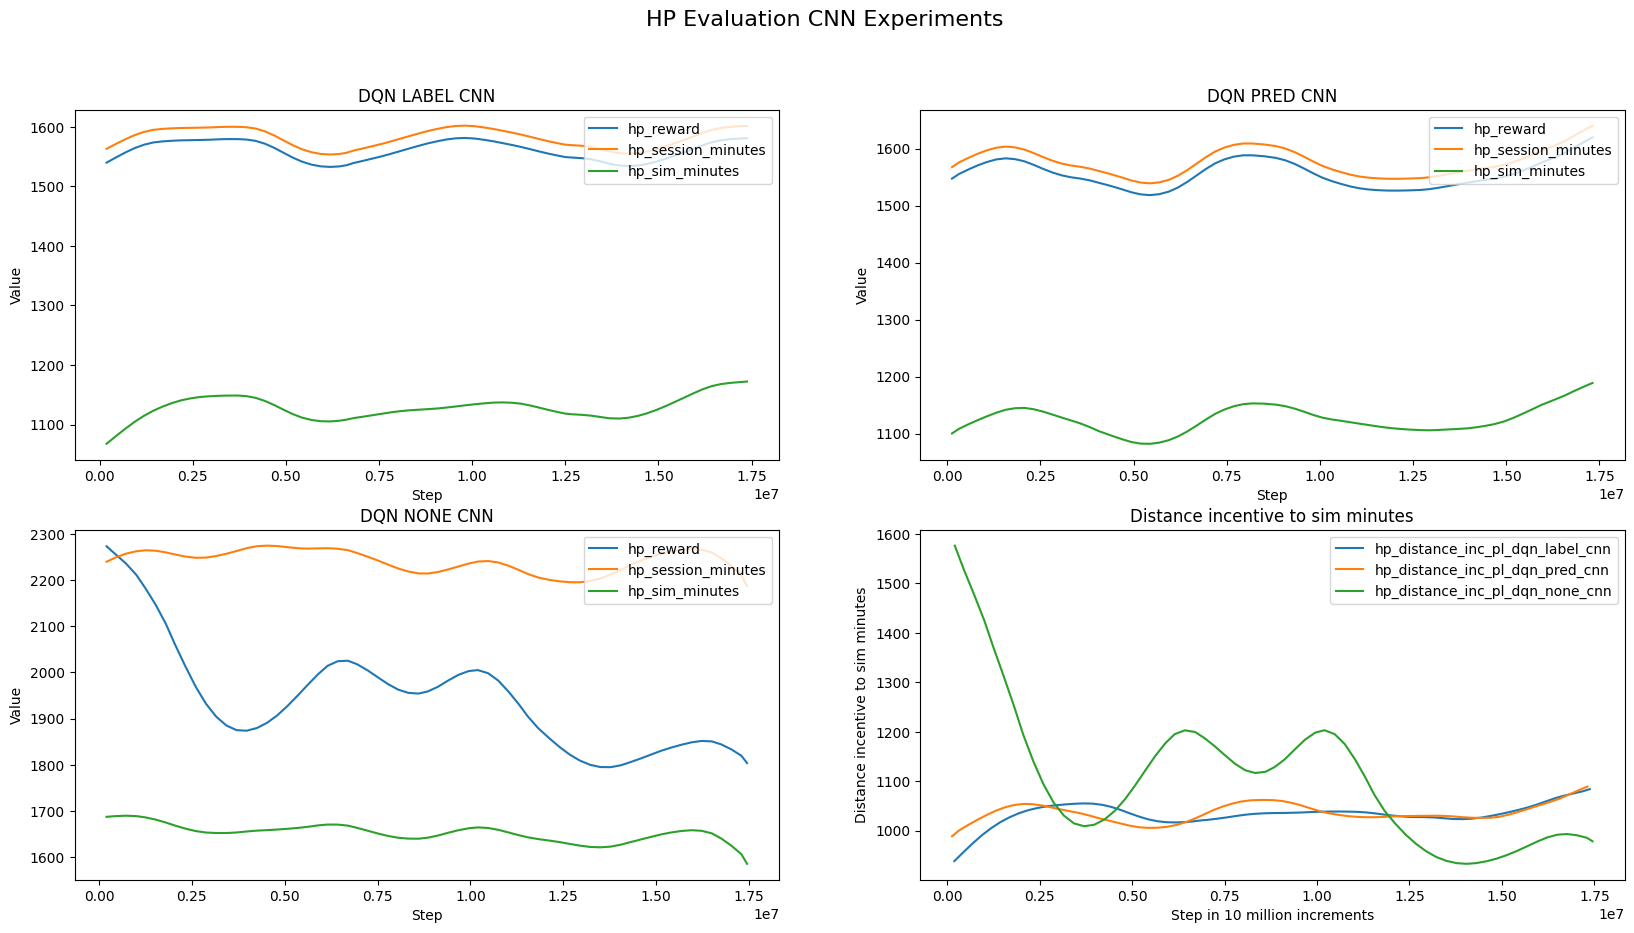

In [39]:
experiments = list(df_summary_stats.keys())

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()


for i, exp_name in enumerate(experiments):
    current_exp = df_summary_stats[exp_name]
    current_exp = current_exp[current_exp['step'] > 52_500]
    current_ax = axs[i]
    for col in ['hp_reward', 'hp_session_minutes', 'hp_sim_minutes']:
        sns.lineplot(x='step', y=col, data=current_exp, ax=current_ax, label=col)
    current_ax.set_title(exp_name)
    current_ax.set_xlabel('Step')
    current_ax.set_ylabel('Value')
    current_ax.legend(loc='upper right')


for i, exp_name in enumerate(experiments):
    current_exp = df_summary_stats[exp_name]
    current_exp = current_exp[current_exp['step'] > 52_500]
    current_ax = axs[-1]
    col = 'hp_distance_inc_pl'
    exp_name = re.sub(r'[^a-zA-Z0-9]', '_', exp_name).lower()
    sns.lineplot(x='step', y=col, data=current_exp, ax=current_ax, label=col + f'_{exp_name}')
    current_ax.set_xlabel('Step in 10 million increments')
    current_ax.set_ylabel('Distance incentive to sim minutes')

current_ax.set_title('Distance incentive to sim minutes')
fig.suptitle('HP Evaluation CNN Experiments', fontsize=16)

result = fetch_end_evaluation(df_summary_stats)
print(result.to_latex(index=False))
result



In [40]:
if not os.path.exists(results_dir):

    reward_dict = tensorboard_results_reward(log_dirs_q1)
    for label, reward in reward_dict.items():
        label = re.sub(r'[^a-zA-Z0-9]', '_', label.lower())
        reward.to_csv(f'{results_dir}/{label}_reward.csv', index=False)
        

    loss_dict = tensorboard_results_loss(log_dirs_q1)
    for label, loss in loss_dict.items():
        label = re.sub(r'[^a-zA-Z0-9]', '_', label.lower())
        loss.to_csv(f'{results_dir}/{label}_loss.csv', index=False)

\begin{tabular}{lrr}
\toprule
Exp Name & hp_reward & hp_loss \\
\midrule
DQN LABEL CNN & 8844.857681 & 655.942537 \\
DQN PRED CNN & 8578.206135 & 654.007133 \\
DQN NONE CNN & 16607.098213 & 1697.609366 \\
\bottomrule
\end{tabular}



,Exp Name,hp_reward,hp_loss
0,DQN LABEL CNN,8844.857681,655.942537
1,DQN PRED CNN,8578.206135,654.007133
2,DQN NONE CNN,16607.098213,1697.609366


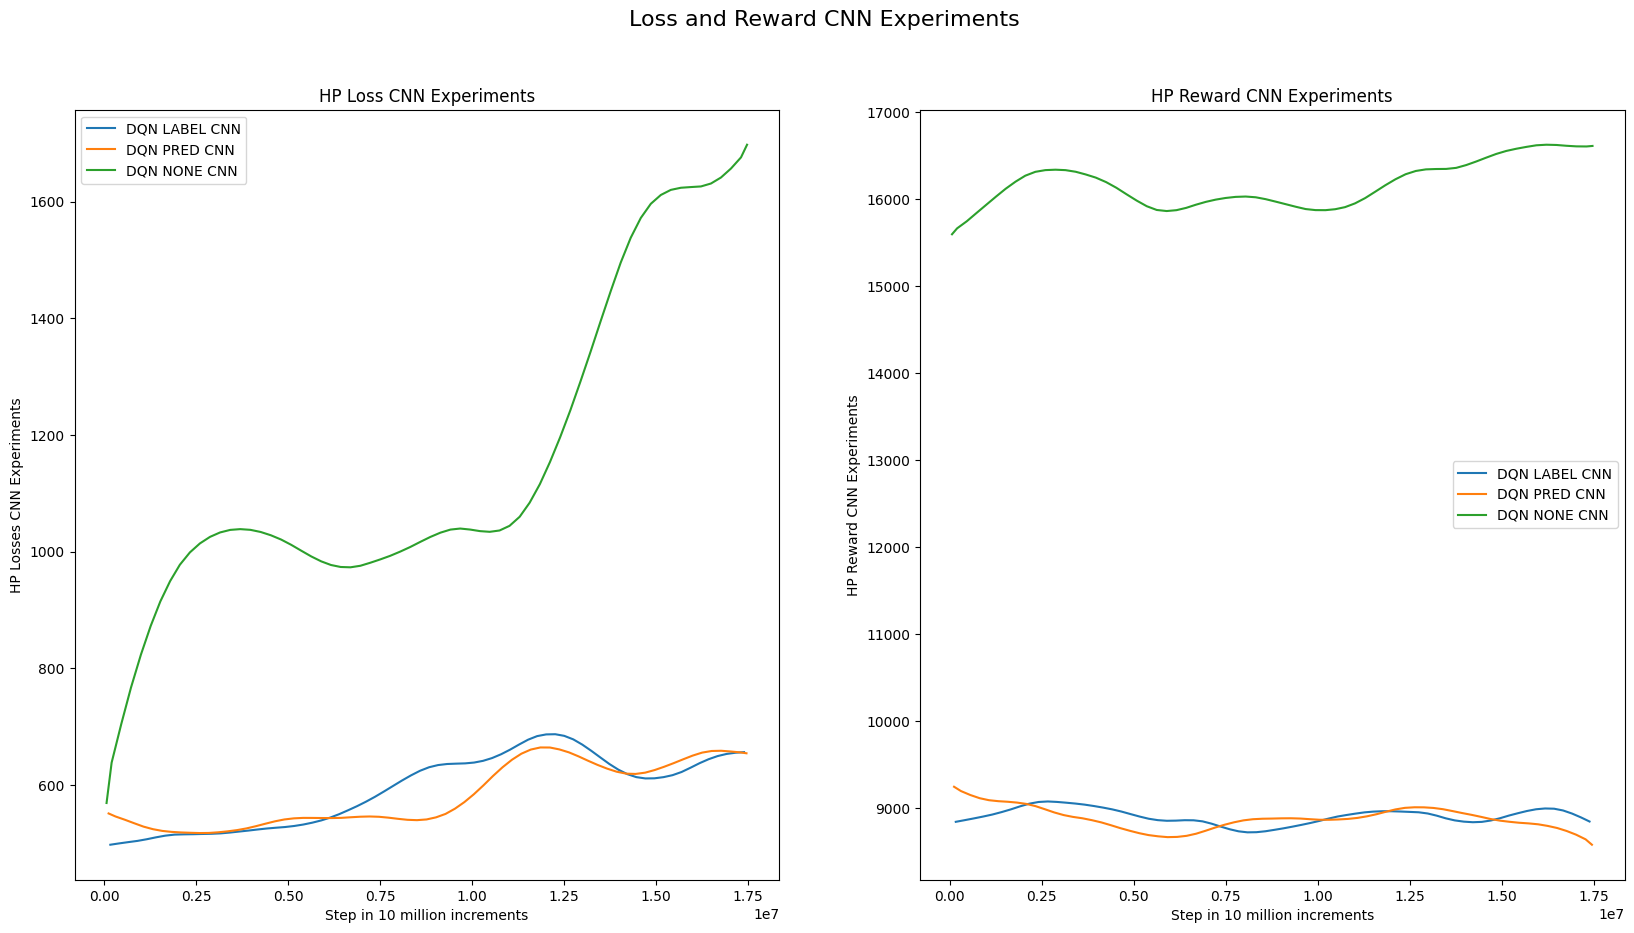

In [41]:
loss_stats = glob.glob(f'{results_dir}/*_loss.csv')
reward_stats = glob.glob(f'{results_dir}/*_reward.csv')

container = [
    'DQN LABEL CNN',
    'DQN PRED CNN',
    'DQN NONE CNN'
]

loss_matrix = {}
reward_matrix = {}

for exp in container:
    exp_match = re.sub(r'[^a-zA-Z0-9]', '_', exp.lower())
    loss_file = next(x for x in loss_stats if exp_match in re.sub(r'[^a-zA-Z0-9]', '_', x.lower()))
    reward_file = next(x for x in reward_stats if exp_match in re.sub(r'[^a-zA-Z0-9]', '_', x.lower())
                       )
    loss_matrix[exp] = pd.read_csv(loss_file)
    loss_matrix[exp]['wall_time'] = pd.to_datetime(loss_matrix[exp]['wall_time'])
    loss_matrix[exp] = loss_matrix[exp][loss_matrix[exp]['step'] < 17_500_000]
    loss_matrix[exp] = loss_matrix[exp][loss_matrix[exp]['step'] > 52_500]
    
    reward_matrix[exp] = pd.read_csv(reward_file)
    reward_matrix[exp]['wall_time'] = pd.to_datetime(reward_matrix[exp]['wall_time'])
    reward_matrix[exp] = reward_matrix[exp][reward_matrix[exp]['step'] < 17_500_000]
    reward_matrix[exp] = reward_matrix[exp][reward_matrix[exp]['step'] > 52_500]
    reward_matrix[exp] = convolve_and_apply_hp_filter(reward_matrix[exp].copy(), 'reward', 5, 100)
    loss_matrix[exp] = convolve_and_apply_hp_filter(loss_matrix[exp].copy(), 'loss', 5, 100)


    
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
loss_ax = axs[0]
reward_ax = axs[1]

for exp_name, df in loss_matrix.items():
    sns.lineplot(x='step', y='hp_loss', data=df, ax=loss_ax, label=exp_name) 
loss_ax.set_title('HP Loss CNN Experiments')
loss_ax.set_xlabel('Step in 10 million increments')
loss_ax.set_ylabel('HP Losses CNN Experiments')

for exp_name, df in reward_matrix.items():
    sns.lineplot(x='step', y='hp_reward', data=df, ax=reward_ax, label=exp_name)
reward_ax.set_title('HP Reward CNN Experiments')
reward_ax.set_xlabel('Step in 10 million increments')
reward_ax.set_ylabel('HP Reward CNN Experiments')

fig.suptitle('Loss and Reward CNN Experiments', fontsize=16)


max_reward = fetch_end_filtered(reward_matrix, 'hp_reward')
max_loss = fetch_end_filtered(loss_matrix, 'hp_loss')

max_df = pd.merge(max_reward, max_loss, on='Exp Name')

max_df
print(max_df.to_latex(index=False))
max_df  
# max_results = fetch_end_filtered(loss_matrix, 'hp_loss')
